In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd 

import jax 
import jax_cosmo as jc 
import jax.numpy as jnp
import jax.scipy as jsp

In [139]:
# Cosmology 
cosmo = jc.Cosmology(Omega_c=0.238, Omega_b=0.047, h=0.7, sigma8 = 0.8, n_s=0.96,
         Omega_k=0., w0=-1., wa=0.)

# Constants 
c = jc.constants.c
H0 = jc.constants.H0 * cosmo.h

In [283]:
# Ranges 
ellvec = np.linspace(1, 500, 101).astype(int)
kvec = np.logspace(-4, np.log10(4), 2000)
zvec = np.linspace(0.0, 0.5, 150)
avec = 1/(1+zvec)

# Smail parameters (smail) - Blazek+2019
n_smail = 1.78e+04
a_smail = 1.64e+00
b_smail = 3.73e+00
z0_smail = 4.10e-1

In [284]:
# Redshift distribution
nzvec = jc.redshift.smail_nz(a_smail, b_smail, z0_smail)

# Velocity Tracer 
tracer_vv = jc.probes.PeculiarVelocity([nzvec])

# Velocity Window Function
window_vv = tracer_vv.kernel(cosmo, zvec, ellvec)

ValueError: Incompatible shapes for broadcasting: shapes=[(101,), (1, 150)]

### Limber 

In [276]:
cl_limber = jc.angular_cl.angular_cl(cosmo, ellvec, [tracer_vv])

/Users/joaopedrobonifacio/anaconda3/envs/firecrown_developer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


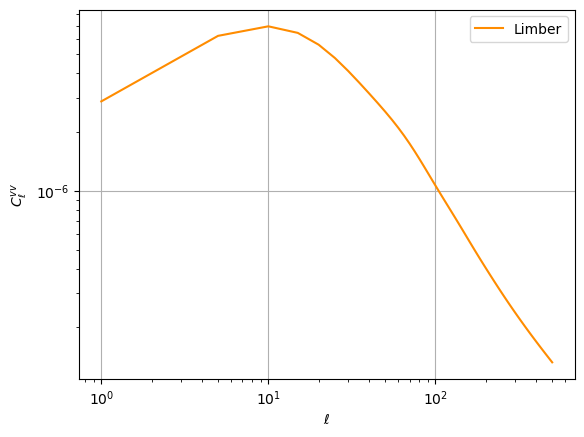

In [277]:
plt.plot(ellvec, cl_limber[0], color='darkorange', label='Limber')
plt.loglog()
plt.ylabel('$C_{\ell}^{vv}$')
plt.xlabel('$\ell$')
plt.grid()
plt.legend();


### Non-Limber 

In [272]:
import pyccl as ccl

cosmo_ccl = ccl.Cosmology(Omega_c=0.238, Omega_b=0.047, h=0.7, n_s=0.96, sigma8=0.8,
        Neff=0, transfer_function="eisenstein_hu", matter_power_spectrum="halofit")


def velocity_kernel_integrand(chi, ell, k, window):

    j_prime = sp.special.spherical_jn(ell, np.outer(k, chi), derivative=True) 
    window = sp.interpolate.splev(chi, window, ext=0)

    return window * j_prime 

def cell_integrand(k, window1, window2):

    
    #pk = ccl.nonlin_matter_power(cosmo_ccl, k, 1.0)
    pk = ccl.nonlin_matter_power(cosmo_ccl, k*cosmo.h, 1.0)*cosmo.h**3
    #pk = jc.power.nonlinear_matter_power(cosmo, k, 1.0)
    window1 = sp.interpolate.splev(k, window1, ext=0)
    window2 = sp.interpolate.splev(k, window2, ext=0)

    return window1 * window2 * pk 

def velocity_cl(chi, window_chi, ks, ells, output_file_path):

    cl_vv = np.zeros(len(ells))

    for i, ell in enumerate(ells):
        velocity_kernel = np.zeros(len(ks))
        for k, kval in enumerate(ks):
            velocity_kernel[k] = sp.integrate.quad(velocity_kernel_integrand, chi[0], chi[-1], args=(ell, kval, window_chi), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
        velocity_kernel_spline = sp.interpolate.splrep(ks, velocity_kernel)
        cl_vv[i] = (2/np.pi) * sp.integrate.quad(cell_integrand, ks[0], ks[-1], args=(velocity_kernel_spline, velocity_kernel_spline), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
        print(ell, cl_vv[i]) 
        #break
    
    np.savetxt(output_file_path, cl_vv, fmt="%g", header="Cl_uu")
    return cl_vv



In [273]:
file_path = '/Users/joaopedrobonifacio/Documents/lib/python/jax_cosmo/notebooks/cl_vv_non_limber.csv'

chi = jc.background.radial_comoving_distance(cosmo, avec)

window_chi_smail = sp.interpolate.splrep(chi, window_vv[0] * jc.background.growth_factor(cosmo, avec) * jc.background.H(cosmo, avec) / c / (zvec[1] - zvec[0]) / np.sum(nzvec(zvec)))

# Calculating the Cell_uu
cl_non_limber = velocity_cl(chi, window_chi_smail, kvec, ellvec, file_path)


1 2218.3957721100687
5 176.78888982550717
10 29.62767216063747
15 8.460282566185505
20 3.149437530472676
25 1.3731989308754753
30 0.6658582917213276
35 0.34984940907140677
40 0.19652132130282277
45 0.11708006883295241
50 0.07351807143245623
55 0.048375336880624405
60 0.033164694967658205


/var/folders/nc/q08wj91x3_94kqtckryqhfxh0000gn/T/ipykernel_99757/3114305802.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  cl_vv[i] = (2/np.pi) * sp.integrate.quad(cell_integrand, ks[0], ks[-1], args=(velocity_kernel_spline, velocity_kernel_spline), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]


65 0.023551039650587392
70 0.017219698232618676
75 0.012885822003946357
80 0.00981211923143282
85 0.007564196256059487
90 0.0058799812696636545
95 0.004596590942837564
100 0.0036090726649198055
105 0.002846634479876398
110 0.0022585401933888872
115 0.0018062503412111
120 0.001459263684003772
125 0.0011930831044805114
130 0.0009881464336677951
135 0.0008290312974737158
140 0.0007037623573041054
145 0.0006033074688166287
150 0.000521037957332496
155 0.0004521994610867136
160 0.00039352616766189175
165 0.00034286928054374024
170 0.000298813068164973
175 0.0002604290770334525
180 0.00022710283490279292
185 0.00019835426319484624
190 0.0001737232196263353
195 0.0001527506321896601
200 0.00013498552392604026
205 0.00011996949550620368
210 0.00010724631535832277
215 9.639401405397414e-05
220 8.704595456626561e-05
225 7.890018351051254e-05
230 7.170759431188926e-05
235 6.526604246291562e-05
240 5.943635629007041e-05
245 5.4141042328900566e-05
250 4.934020386162132e-05
255 4.500826511337978e-05

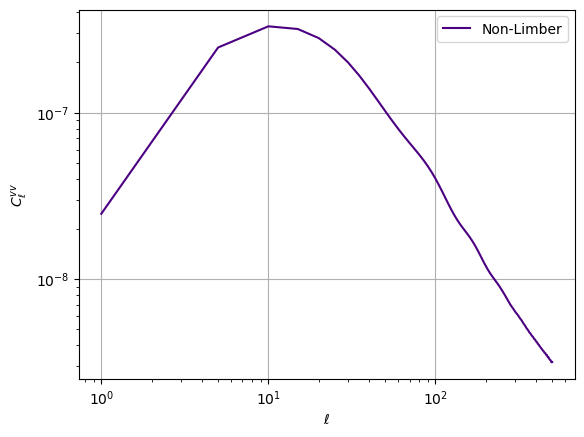

In [275]:
plt.plot(ellvec, cl_non_limber*(ellvec**3/c**2), color='indigo', label='Non-Limber')
plt.loglog()
plt.ylabel('$C_{\ell}^{vv}$')
plt.xlabel('$\ell$')
plt.grid()
plt.legend();

### Comprison between Limber and Non-Limber

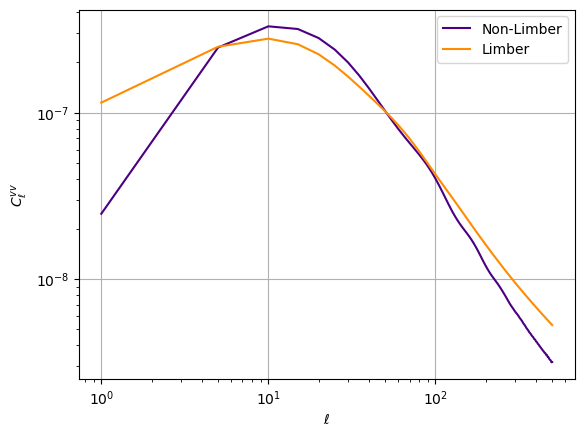

In [285]:
plt.plot(ellvec, cl_non_limber*(ellvec**3/c**2), color='indigo', label='Non-Limber')
plt.plot(ellvec, cl_limber[0]/25, color='darkorange', label='Limber')
plt.loglog()
plt.ylabel('$C_{\ell}^{vv}$')
plt.xlabel('$\ell$')
plt.grid()
plt.legend(); 

# Dependendo dar curva faz o plot da diff rel.